# Trento course code

## Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

# Day 2 

## 1DSWE

### Functions

In [3]:
def Phi(hstar, hi):
    g = 9.81 # Gravitational constant
    if hstar <= hi:
        # Shock wave
        F = 2 * (np.sqrt(g * hstar) - np.sqrt(g * hi))
    else:
        # Rarefaction wave
        F = np.sqrt(0.5 * g * (hstar + hi) / (hstar * hi)) * (hstar - hi)

    return F


def G(hstar, hL, hR, uL, uR):
    return Phi(hstar, hL) + Phi(hstar, hR) + uR - uL

def dG(hstar, hL, hR, uL, uR):
    eps = 1e-8

    # Compute the finite difference
    res = (G(hstar + eps, hL, hR, uL, uR) - G(hstar - eps, hL, hR, uL, uR)) / (2 * eps)

    return res

def f(q, g):
    F = np.zeros(2)  # Create an array of zeros with size 2
    F[0] = q[1]  # h * u
    F[1] = (q[1] ** 2) / q[0] + 0.5 * g * (q[0] ** 2)  # h * u^2 + 1/2 * g * h^2
    
    return F

def Lambda(q, Nx, g):
    u = q[1, :] / q[0, :]  # Velocity u
    h = q[0, :]            # Height h

    L = np.zeros((2, Nx))  # Create a 2xNx array of zeros
    L[0, :] = u - np.sqrt(g * h)  # L1 = u - sqrt(g * h)
    L[1, :] = u + np.sqrt(g * h)  # L2 = u + sqrt(g * h)

    return L

def Newton(hL, hR, uL, uR, g):
    tol = 1e-10
    hstar = (hL + hR) / 2
    MaxIter = 100

    for i in range(MaxIter):
        residual = G(hstar, hL, hR, uL, uR)  
        if abs(residual) < tol:
            break

        dhstar = -residual / dG(hstar, hL, hR, uL, uR)  
        d = 1

        # Optimization of the Newton method
        for inner in range(MaxIter):
            if abs(G(hstar + d * dhstar, hL, hR, uL, uR)) >= abs(residual):
                # Residual is growing - NOT good
                d *= 0.5
            else:
                # Residual is decreasing - good
                hstar += d * dhstar
                break

    return hstar


In [4]:
def ExactRP(QL, QR, lambda_val, g):
    # Unpack left and right states
    hL = QL[0]
    hR = QR[0]
    uL = QL[1] / hL
    uR = QR[1] / hR

    # Compute the star solution hstar and ustar
    hstar = Newton(hL, hR, uL, uR, g)  
    ustar = uL - Phi(hstar, hL)

    # Sampling of the left wave
    if lambda_val <= ustar:  # Sampling of the left wave
        if hstar > hL:  # Left wave is a shock
            s = uL - np.sqrt(0.5 * g * hstar / hL * (hstar + hL))
            if lambda_val <= s:
                Q = np.array([hL, hL * uL])
            else:
                Q = np.array([hstar, hstar * ustar])
        else:  # Left wave is a rarefaction
            urw_head = uL - np.sqrt(g * hL)  # Velocity of the head of the rarefaction wave
            urw_tail = ustar - np.sqrt(g * hstar)  # Velocity of the tail of the rarefaction wave
            if lambda_val <= urw_head:
                # x_{i+1/2} is in the QL region
                Q = np.array([hL, hL * uL])
            elif lambda_val >= urw_tail:
                # x_{i+1/2} is in the Qstar region
                Q = np.array([hstar, hstar * ustar])
            else:
                # x_{i+1/2} is in the rarefaction wave
                h = ((uL + 2 * np.sqrt(g * hL) - lambda_val) / 3) ** 2 / g
                Q = np.array([h, h * (lambda_val + np.sqrt(g * h))])

    else:  # Sampling of the right wave
        if hstar > hR:  # Right wave is a shock
            s = uR + np.sqrt(0.5 * g * hstar / hR * (hstar + hR))
            if lambda_val <= s:
                Q = np.array([hstar, hstar * ustar])
            else:
                Q = np.array([hR, hR * uR])
        else:  # Right wave is a rarefaction
            urw_head = uR + np.sqrt(g * hR)  # Velocity of the head of the rarefaction wave
            urw_tail = ustar + np.sqrt(g * hstar)  # Velocity of the tail of the rarefaction wave
            if lambda_val >= urw_head:
                # x_{i+1/2} is in the QL region
                Q = np.array([hR, hR * uR])
            elif lambda_val <= urw_tail:
                # x_{i+1/2} is in the Qstar region
                Q = np.array([hstar, hstar * ustar])
            else:
                # x_{i+1/2} is in the rarefaction wave
                h = ((-uR + 2 * np.sqrt(g * hR) + lambda_val) / 3) ** 2 / g
                Q = np.array([h, h * (lambda_val - np.sqrt(g * h))])

    return Q


### Verify solution

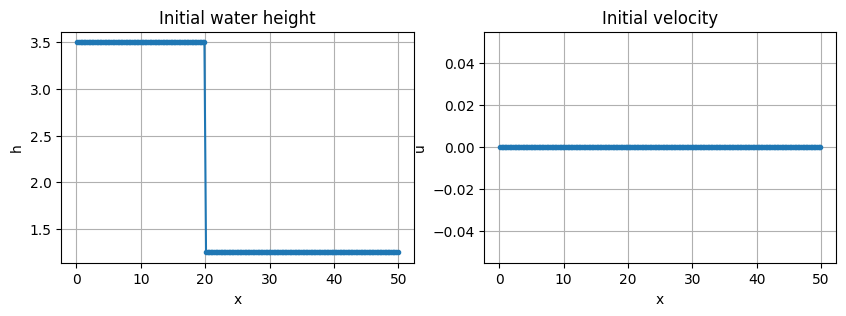

In [5]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 3.5
hR = 1.25
#q[0, :Nx//2] = hL
#q[0, Nx//2:] = hR
#q = np.where(x < 20, hL, hR)
q[0, :] = np.where(x < 20, hL, hR)
qnew = q.copy()

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

In [6]:
tend = 2.5

# Compute the total amount of water content in the domain (integral of h between xL and xR)
H0 = np.sum(dx * q[0, :])

# Time loop
for n in range(1000000):
    amax = np.max(np.abs(Lambda(q, Nx, g)))
    dt = CFL * dx / amax
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break  # Stop the time loop

    # Space loop
    dtdx = dt / dx
    for i in range(Nx):
        if i == 0:
            q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
            q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
            qm = ExactRP(q_ghost, q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        elif i == Nx - 1:
            q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
            q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
            qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q_ghost, 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        else:
            qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

    # Update time and solution
    t += dt
    q = qnew.copy()


In [7]:
# Load the .mat file
mat_data = loadmat('dambreakdata.mat')

h_sol = mat_data['h']
u_sol = mat_data['u']

h_sol = np.array(h_sol[0, :])
u_sol = np.array(u_sol[0, :])

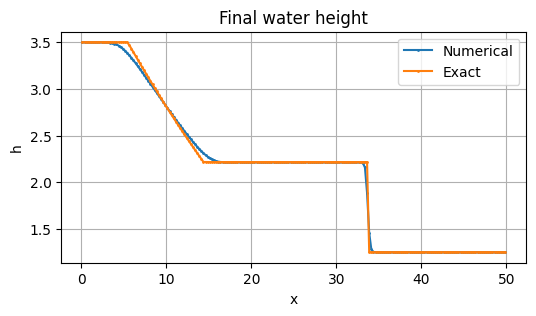

In [8]:
# Plot the final data
plt.figure(figsize=(6, 3))
plt.plot(x, q[0, :], '-o', markersize = 1)
plt.plot(x, h_sol, '-o', markersize = 1)
plt.legend(['Numerical', 'Exact'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Final water height')
plt.show()


### Original

In [9]:
tend = 2.5

# Compute the total amount of water content in the domain (integral of h between xL and xR)
H0 = np.sum(dx * q[0, :])

# Time loop
for n in range(1000000):
    amax = np.max(np.abs(Lambda(q, Nx, g)))
    dt = CFL * dx / amax
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break  # Stop the time loop

    # Space loop
    dtdx = dt / dx
    for i in range(Nx):
        if i == 0:
            q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
            q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
            qm = ExactRP(q_ghost, q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        elif i == Nx - 1:
            q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
            q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
            qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q_ghost, 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        else:
            qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

    # Update time and solution
    t += dt
    q = qnew.copy()


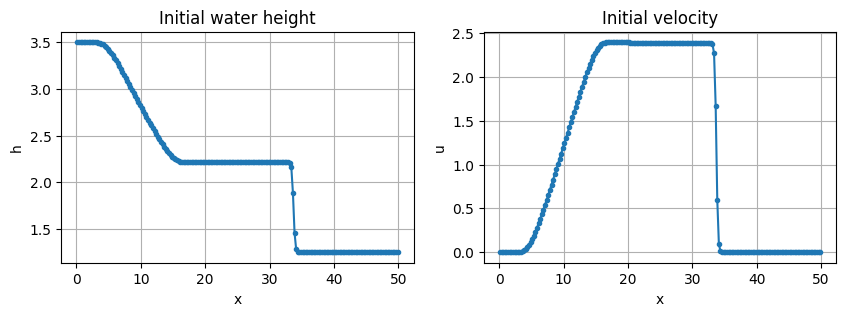

In [10]:
# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

# Toro test cases

In [52]:
# Define function
def solve_SWE_1D(q, Nx, dx, CFL, g, t, tend):

    qnew = q.copy()

    # Compute the total amount of water content in the domain (integral of h between xL and xR)
    H0 = np.sum(dx * q[0, :])

    # Time loop
    for n in range(1000000):
        amax = np.max(np.abs(Lambda(q, Nx, g)))
        dt = CFL * dx / amax
        if t + dt > tend:
            dt = tend - t
        if t >= tend:
            break  # Stop the time loop

        # Space loop
        dtdx = dt / dx
        for i in range(Nx):
            if i == 0:
                q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
                q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
                qm = ExactRP(q_ghost, q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
                fm = f(qm, g)
                qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
                fp = f(qp, g)
                # Standard Finite-Volume update
                qnew[:, i] = q[:, i] - dtdx * (fp - fm)

            elif i == Nx - 1:
                q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
                q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
                qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
                fm = f(qm, g)
                qp = ExactRP(q[:, i], q_ghost, 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
                fp = f(qp, g)
                # Standard Finite-Volume update
                qnew[:, i] = q[:, i] - dtdx * (fp - fm)

            else:
                qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
                fm = f(qm, g)
                qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
                fp = f(qp, g)
                # Standard Finite-Volume update
                qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        # Update time and solution
        t += dt
        q = qnew.copy()
    return q


## Test 1

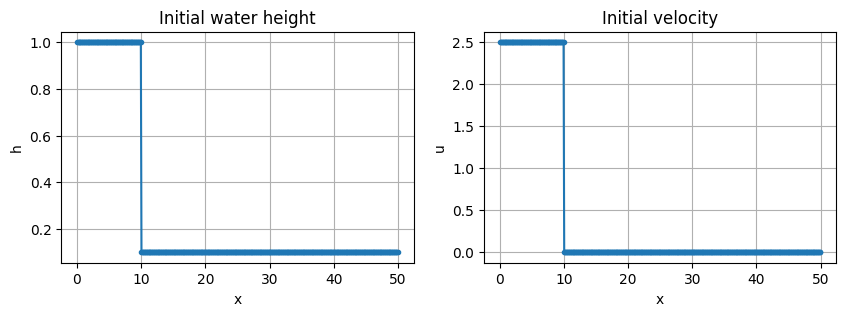

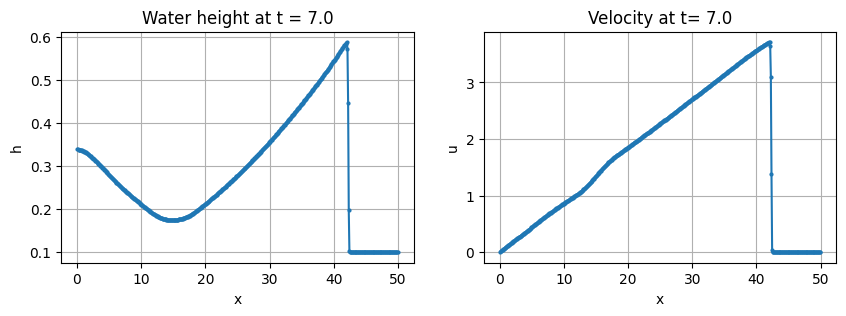

In [62]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 500  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 1.0
hR = 0.1
uL = 2.5
uR = 0.0
x0 = 10.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

# Solve the SWE
tend = 7.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

plt.show()


## Test 2

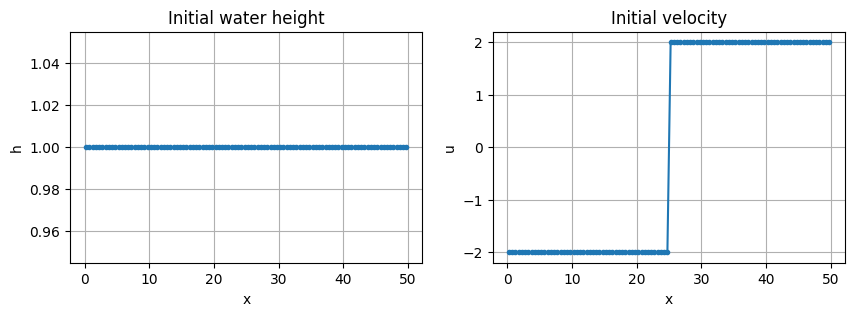

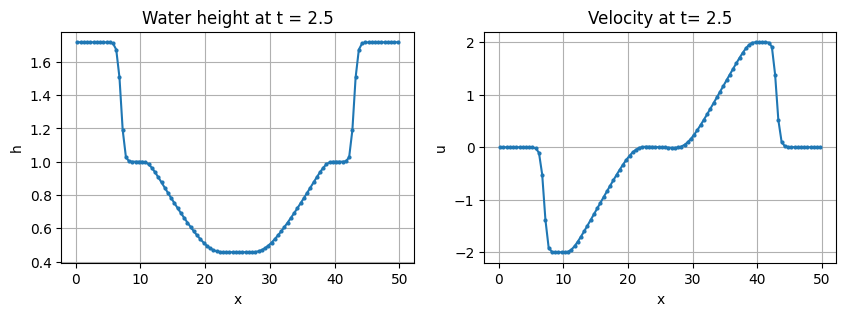

In [66]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx =  100  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 1.0
hR = 1.0
uL = -2
uR = 2
x0 = 25.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

# Solve the SWE
tend = 2.5
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

plt.show()


## Test 3

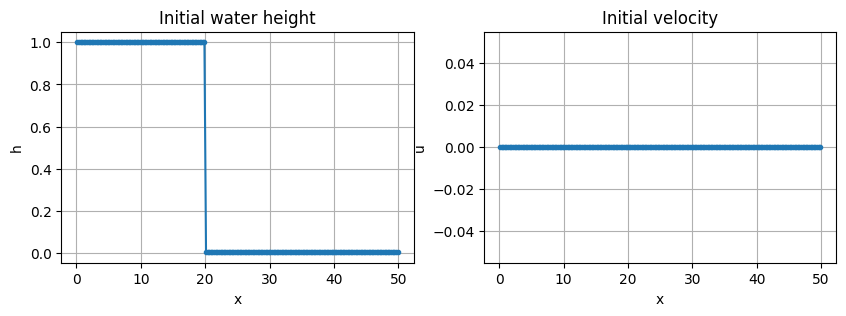

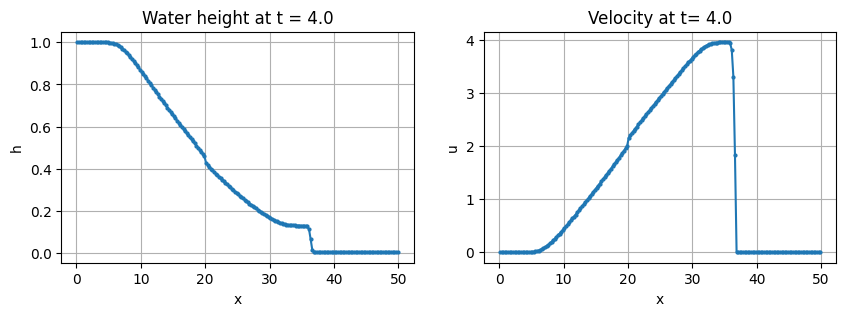

In [59]:
# Physical parameters
xL = 0
xR = 50
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 1.0
hR = 0.005
uL = 0.0
uR = 0.0
x0 = 20.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

# Solve the 1D SWE
tend = 4.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

plt.show()


## Test 4

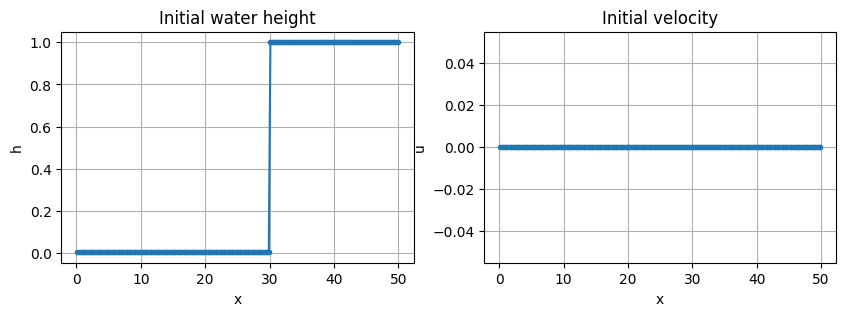

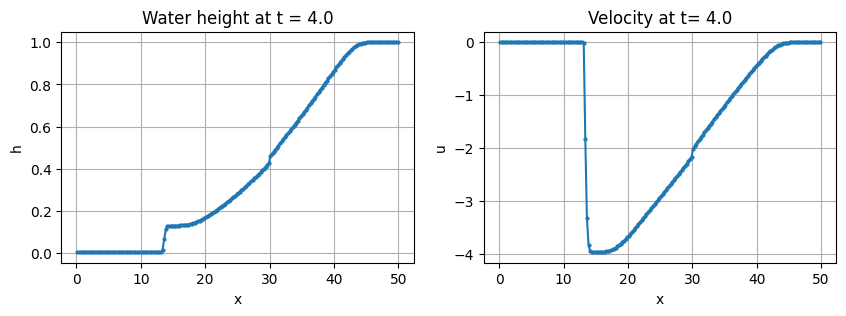

In [67]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 0.005
hR = 1.0
uL = 0.0
uR = 0.0
x0 = 30.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

# Solve the SWE
tend = 4.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

plt.show()


## Test 5

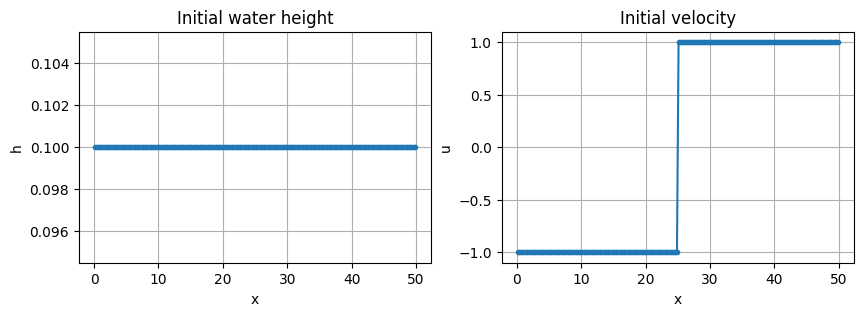

C:\Users\Matteo\AppData\Local\Temp\ipykernel_15692\2691461147.py:5: RuntimeWarning: invalid value encountered in sqrt
  F = 2 * (np.sqrt(g * hstar) - np.sqrt(g * hi))


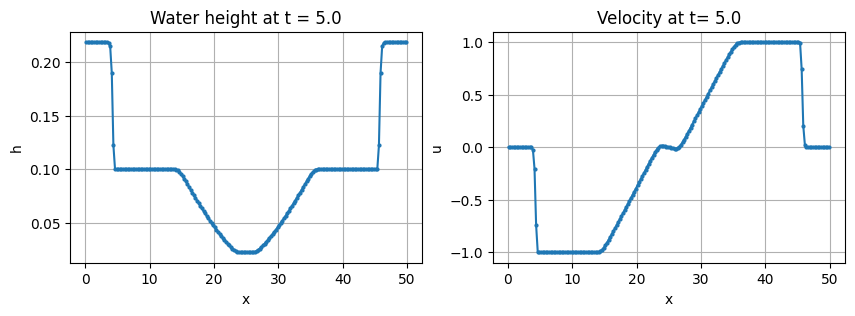

In [69]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 0.1
hR = 0.1
uL = -1.0
uR = 1.0
x0 = 25.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

# Solve the SWE
tend = 5.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

plt.show()


# Day 3 - SWE 2D
The MUSCL-Hancock scheme for the 2D SWE with the Rusanov numerical flux.

In [11]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


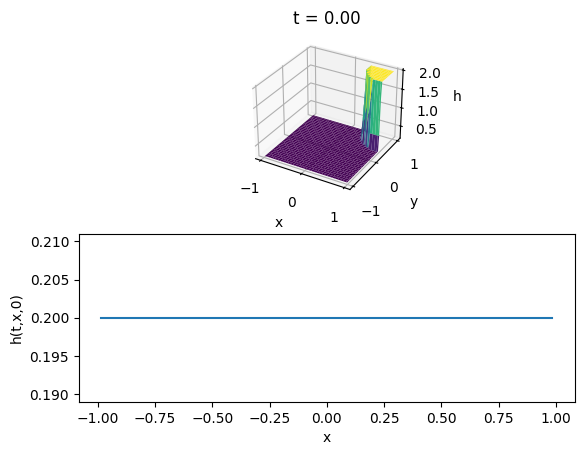

In [12]:
# Global constants
g = 9.81  # gravity
Nx = 64
Ny = Nx
xL, xR = -1, 1
yL, yR = -1, 1
t = 0
tend = 0.1 # 1 
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)
for i in range(Nx):
    for j in range(Ny):
        r = np.sqrt((x[i] - 0.9)**2 + (y[j] - 0.9)**2)
        if r < 0.5:
            Q[0, i, j] = 2
        else:
            Q[0, i, j] = 0.2

fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
            elif i == Nx - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
            elif j == Ny - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)

    # Update time and solution
    t += dt
    Q = np.copy(Qnew)

    # Plot the solution
    ax1.clear()
    ax1.plot_surface(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], Q[0, :, :], cmap='viridis')
    ax1.set_title(f't = {t:.2f}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('h')

    ax2.clear()
    ax2.plot(x, Q[0, :, Ny // 2])
    ax2.set_xlabel('x')
    ax2.set_ylabel('h(t,x,0)')

    plt.pause(0.1)

plt.show()


In [13]:
Q.shape

(3, 64, 64)

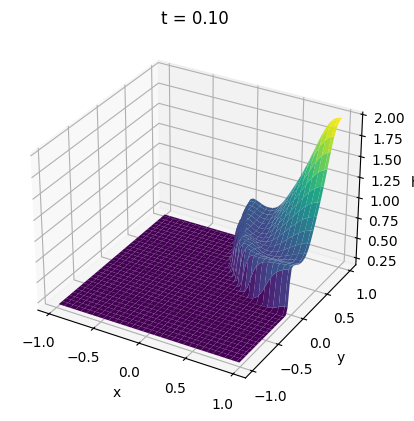

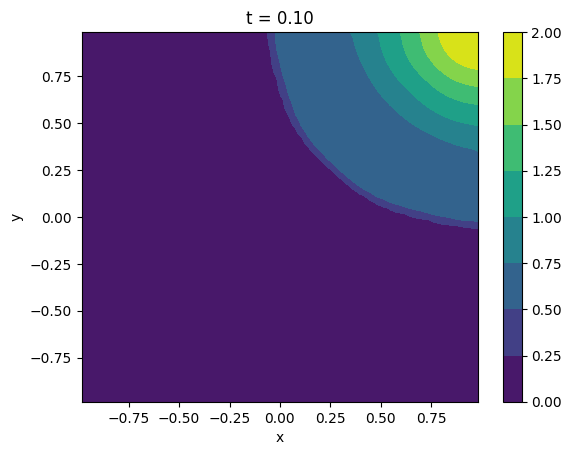

In [14]:
# Plot the final data in 3d and in contour
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], Q[0, :, :], cmap='viridis')
ax.set_title(f't = {t:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('h')
plt.show()

plt.figure()
plt.contourf(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], Q[0, :], cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f't = {t:.2f}')
plt.show()

